In [1]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

In [2]:
'''# Cargo de Google Drive los archivos

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id_train_transaction='19setxTbNvfO5L5h-9h5-bcFcl7Ml1kHt'
downloaded = drive.CreateFile({'id': id_train_transaction})
downloaded.GetContentFile('train_transaction.csv')

id_train_identity = '1XUUs36t6K2ByA7xuQuTzRH_smXVtmVjF'
downloaded = drive.CreateFile({'id': id_train_identity})
downloaded.GetContentFile('train_identity.csv')

id_test_transaction='1LnLkTi7YYu95qlR6r7fDGbQUJrNR2uYE'
downloaded = drive.CreateFile({'id': id_test_transaction})
downloaded.GetContentFile('test_transaction.csv')

id_test_identity = '1Pro4HlgAnTo2UmGhS7NReITPAJxxPolA'
downloaded = drive.CreateFile({'id': id_test_identity})
downloaded.GetContentFile('test_identity.csv')

'''

"# Cargo de Google Drive los archivos\n\nfrom pydrive.auth import GoogleAuth\nfrom pydrive.drive import GoogleDrive\nfrom google.colab import auth\nfrom oauth2client.client import GoogleCredentials\n\n\nauth.authenticate_user()\ngauth = GoogleAuth()\ngauth.credentials = GoogleCredentials.get_application_default()\ndrive = GoogleDrive(gauth)\n\nid_train_transaction='19setxTbNvfO5L5h-9h5-bcFcl7Ml1kHt'\ndownloaded = drive.CreateFile({'id': id_train_transaction})\ndownloaded.GetContentFile('train_transaction.csv')\n\nid_train_identity = '1XUUs36t6K2ByA7xuQuTzRH_smXVtmVjF'\ndownloaded = drive.CreateFile({'id': id_train_identity})\ndownloaded.GetContentFile('train_identity.csv')\n\nid_test_transaction='1LnLkTi7YYu95qlR6r7fDGbQUJrNR2uYE'\ndownloaded = drive.CreateFile({'id': id_test_transaction})\ndownloaded.GetContentFile('test_transaction.csv')\n\nid_test_identity = '1Pro4HlgAnTo2UmGhS7NReITPAJxxPolA'\ndownloaded = drive.CreateFile({'id': id_test_identity})\ndownloaded.GetContentFile('test_

In [3]:
train_identity = pd.read_csv('./ieee-fraud-detection/train_identity.csv')

train_transaction = pd.read_csv('./ieee-fraud-detection/train_transaction.csv')

# Analizo los datasets

In [4]:
train_identity

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,...,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,...,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS


In [5]:
train_transaction

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> ***Observo que train_transaction tiene una columna de TransactionDT.***



Esta es una columna es de tipo datetime y representa el tiempo transcurrido desde un instante de referencia (desconocido). 

Esto significa que debe permanecer ordenada para evitar time-travel. 

In [6]:
# Verifico que esten ordenado los registros en el tiempo

list(train_transaction.TransactionDT) == sorted(train_transaction.TransactionDT, reverse=False)

True

# Busco el dataset completo con el que voy a trabajar

Uno los data sets de trainning que nos dan.

In [7]:
all_data = train_transaction.merge(train_identity, on='TransactionID', how='outer')

In [8]:
import gc

# Libero memoria del sistema
del(train_transaction)
del(train_identity)

# using the garbage collector to manually collect the garbage
gc.collect()

20

Este truco lo saque de Kaggle para administrar la memoria.

In [9]:
display(all_data)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Verifico que mantenga el orden segun TransactionDT

In [10]:
all_data.TransactionDT.hasnans

False

In [11]:
list(all_data.TransactionDT) == sorted(all_data.TransactionDT, reverse=False)

True

# Extraigo los target y features del dataset y creo los sets de trainning y testing.

Creo `data_train` y `data_test` para el set de `data` y

`label_train`, `label_test` para el set de `target`.

> Nota: El target es `isFraud`

# Particiono la data como train_set y test_set

Tomo un 20% de la data como `test_set` y el restante para `train_set` del modelo.

Me baso en TransactionDT como separador de registros.

In [12]:
labels = all_data.isFraud

In [13]:
# Tomo el 80% 
ochenta_porciento = int(all_data['TransactionDT'].size * 0.8)

In [14]:
data_train = all_data.iloc[: ochenta_porciento]

data_validation = all_data.iloc[ochenta_porciento:]

In [15]:
label_train = labels.iloc[:ochenta_porciento]

label_validation = labels.iloc[ochenta_porciento:]

# Limpio la data

Para los features categoricos reemplazo los 'nans' por 'desconocido' y para los features numericos los reemplazo por su mean de cada columna.

> Nota: Para el validation test reemplazo los nans por los means correspondientes a las columnas del trainning_set.
>
>  No se vuelven a calcular los means por columnas.

In [16]:
# Busco los promedios de cada columna numerica para el trainning_set

mean_values={}

for i in data_train.columns:
  if (str(data_train[i].dtype) != 'object'):
    mean_values[i] = data_train[i].mean()

In [17]:
# Limpio la data

def limpiar_dataset(dataset, mean_values):
  
  for i in dataset.columns:

    if (str(dataset[i].dtype) != 'object'):
      dataset[i].fillna(mean_values[i], inplace=True)
    
    else:
      dataset[i].fillna('desconocido',inplace=True)

In [18]:
limpiar_dataset(data_train, mean_values)
display(data_train)

/home/paredesj/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,362.861214,150.0,discover,142.0,...,desconocido,26.596037,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
1,2987001,0,86401,29.00,W,2755,404.000000,150.0,mastercard,102.0,...,desconocido,26.596037,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
2,2987002,0,86469,59.00,W,4663,490.000000,150.0,visa,166.0,...,desconocido,26.596037,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
3,2987003,0,86499,50.00,W,18132,567.000000,150.0,mastercard,117.0,...,desconocido,26.596037,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
4,2987004,0,86506,50.00,H,4497,514.000000,150.0,mastercard,102.0,...,samsung browser 6.2,32.000000,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,3459427,0,12192667,43.95,W,15484,418.000000,150.0,visa,226.0,...,desconocido,26.596037,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
472428,3459428,0,12192736,49.00,W,17188,321.000000,150.0,visa,226.0,...,desconocido,26.596037,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
472429,3459429,0,12192742,40.00,H,16659,170.000000,150.0,visa,226.0,...,chrome 65.0,24.000000,1440x900,match_status:2,T,F,T,T,desktop,MacOS
472430,3459430,0,12192743,15.00,W,7919,194.000000,150.0,mastercard,166.0,...,desconocido,26.596037,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido


In [19]:
data_validation

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
472432,3459432,1,12192900,33.261,C,9300,103.0,185.0,visa,138.0,...,chrome 65.0,NaN,NaN,NaN,F,F,T,F,desktop,NaN
472433,3459433,0,12192911,52.811,C,8809,179.0,106.0,visa,137.0,...,chrome generic for android,NaN,NaN,NaN,F,F,T,F,mobile,F3311
472434,3459434,0,12192913,136.956,C,10819,555.0,185.0,visa,226.0,...,chrome 65.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows
472435,3459435,0,12193040,136.956,C,9633,130.0,185.0,visa,138.0,...,chrome 65.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows
472436,3459436,0,12193199,25.000,H,17188,321.0,150.0,visa,226.0,...,firefox 59.0,24.0,3200x1800,match_status:2,T,F,T,T,desktop,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.500,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.950,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
limpiar_dataset(data_validation, mean_values)
display(data_validation)

/home/paredesj/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
472432,3459432,1,12192900,33.261,C,9300,103.000000,185.0,visa,138.0,...,chrome 65.0,26.596037,desconocido,desconocido,F,F,T,F,desktop,desconocido
472433,3459433,0,12192911,52.811,C,8809,179.000000,106.0,visa,137.0,...,chrome generic for android,26.596037,desconocido,desconocido,F,F,T,F,mobile,F3311
472434,3459434,0,12192913,136.956,C,10819,555.000000,185.0,visa,226.0,...,chrome 65.0,26.596037,desconocido,desconocido,F,F,T,F,desktop,Windows
472435,3459435,0,12193040,136.956,C,9633,130.000000,185.0,visa,138.0,...,chrome 65.0,26.596037,desconocido,desconocido,F,F,T,F,desktop,Windows
472436,3459436,0,12193199,25.000,H,17188,321.000000,150.0,visa,226.0,...,firefox 59.0,24.000000,3200x1800,match_status:2,T,F,T,T,desktop,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000,W,6550,362.861214,150.0,visa,226.0,...,desconocido,26.596037,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
590536,3577536,0,15811049,39.500,W,10444,225.000000,150.0,mastercard,224.0,...,desconocido,26.596037,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
590537,3577537,0,15811079,30.950,W,12037,595.000000,150.0,mastercard,224.0,...,desconocido,26.596037,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido
590538,3577538,0,15811088,117.000,W,7826,481.000000,150.0,mastercard,224.0,...,desconocido,26.596037,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido


# Aplico Ordinal Encoding a data_train y luego a validation_train

Guardo los encodings para los features categoricos en un diccionario para luego asignarselos al set de test.

In [21]:
def obtener_columnas_categoricas(data_set):

  columnas_categoricas = []

  for col in data_set.columns:
        if (str(data_set[col].dtype) == 'object'):
            columnas_categoricas.append(col)

  return columnas_categoricas

In [22]:
# Creo el Ordinal Encoder por columna categoricas

from sklearn.preprocessing import OrdinalEncoder


oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe.fit(data_train[obtener_columnas_categoricas(data_train)])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [23]:
# Aplico el encoder al data_train
data_train[obtener_columnas_categoricas(data_train)] = oe.transform(data_train[obtener_columnas_categoricas(data_train)])
display(data_train)

/home/paredesj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/paredesj/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,4.0,13926,362.861214,150.0,2.0,142.0,...,60.0,26.596037,212.0,0.0,2.0,2.0,2.0,2.0,0.0,1578.0
1,2987001,0,86401,29.00,4.0,2755,404.000000,150.0,3.0,102.0,...,60.0,26.596037,212.0,0.0,2.0,2.0,2.0,2.0,0.0,1578.0
2,2987002,0,86469,59.00,4.0,4663,490.000000,150.0,4.0,166.0,...,60.0,26.596037,212.0,0.0,2.0,2.0,2.0,2.0,0.0,1578.0
3,2987003,0,86499,50.00,4.0,18132,567.000000,150.0,3.0,117.0,...,60.0,26.596037,212.0,0.0,2.0,2.0,2.0,2.0,0.0,1578.0
4,2987004,0,86506,50.00,1.0,4497,514.000000,150.0,3.0,102.0,...,104.0,32.000000,135.0,4.0,1.0,0.0,1.0,1.0,2.0,870.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,3459427,0,12192667,43.95,4.0,15484,418.000000,150.0,4.0,226.0,...,60.0,26.596037,212.0,0.0,2.0,2.0,2.0,2.0,0.0,1578.0
472428,3459428,0,12192736,49.00,4.0,17188,321.000000,150.0,4.0,226.0,...,60.0,26.596037,212.0,0.0,2.0,2.0,2.0,2.0,0.0,1578.0
472429,3459429,0,12192742,40.00,1.0,16659,170.000000,150.0,4.0,226.0,...,52.0,24.000000,62.0,4.0,1.0,0.0,1.0,1.0,1.0,661.0
472430,3459430,0,12192743,15.00,4.0,7919,194.000000,150.0,3.0,166.0,...,60.0,26.596037,212.0,0.0,2.0,2.0,2.0,2.0,0.0,1578.0


In [24]:
# Aplico el encoder al data_validation
data_validation[obtener_columnas_categoricas(data_validation)] = oe.transform(data_validation[obtener_columnas_categoricas(data_validation)])
display(data_validation)

/home/paredesj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/paredesj/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
472432,3459432,1,12192900,33.261,0.0,9300,103.000000,185.0,4.0,138.0,...,52.0,26.596037,212.0,0.0,0.0,0.0,1.0,0.0,1.0,1578.0
472433,3459433,0,12192911,52.811,0.0,8809,179.000000,106.0,4.0,137.0,...,56.0,26.596037,212.0,0.0,0.0,0.0,1.0,0.0,2.0,250.0
472434,3459434,0,12192913,136.956,0.0,10819,555.000000,185.0,4.0,226.0,...,52.0,26.596037,212.0,0.0,0.0,0.0,1.0,0.0,1.0,1467.0
472435,3459435,0,12193040,136.956,0.0,9633,130.000000,185.0,4.0,138.0,...,52.0,26.596037,212.0,0.0,0.0,0.0,1.0,0.0,1.0,1467.0
472436,3459436,0,12193199,25.000,1.0,17188,321.000000,150.0,4.0,226.0,...,74.0,24.000000,172.0,4.0,1.0,0.0,1.0,1.0,1.0,1467.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000,4.0,6550,362.861214,150.0,4.0,226.0,...,60.0,26.596037,212.0,0.0,2.0,2.0,2.0,2.0,0.0,1578.0
590536,3577536,0,15811049,39.500,4.0,10444,225.000000,150.0,3.0,224.0,...,60.0,26.596037,212.0,0.0,2.0,2.0,2.0,2.0,0.0,1578.0
590537,3577537,0,15811079,30.950,4.0,12037,595.000000,150.0,3.0,224.0,...,60.0,26.596037,212.0,0.0,2.0,2.0,2.0,2.0,0.0,1578.0
590538,3577538,0,15811088,117.000,4.0,7826,481.000000,150.0,3.0,224.0,...,60.0,26.596037,212.0,0.0,2.0,2.0,2.0,2.0,0.0,1578.0


## Arreglo la data para poder usar el modelo correctamente

In [25]:
data_train = data_train.drop(columns=['isFraud', 'TransactionID'])

In [26]:
data_validation = data_validation.drop(columns=['isFraud', 'TransactionID'])

In [27]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(data_train)

data_train = scaler.fit_transform(data_train)

data_validation =   scaler.transform(data_validation)

In [28]:
data_train

array([[-1.58139727, -0.27741211,  0.56643981, ...,  0.53733463,
        -0.53376046,  0.29682117],
       [-1.58139699, -0.44368749,  0.56643981, ...,  0.53733463,
        -0.53376046,  0.29682117],
       [-1.58137788, -0.31740239,  0.56643981, ...,  0.53733463,
        -0.53376046,  0.29682117],
       ...,
       [ 1.81938916, -0.39738295, -1.50669426, ..., -0.91143876,
         1.00636035, -3.85828064],
       [ 1.81938944, -0.50262053,  0.56643981, ...,  0.53733463,
        -0.53376046,  0.29682117],
       [ 1.81941725, -0.35949742,  0.56643981, ...,  0.53733463,
        -0.53376046,  0.29682117]])

# Creo el Modelo de Regresion Lineal


Teniendo la data ordenada, creo el modelo de regresion lineal para poder entrenar

In [29]:
model = LogisticRegression(C=0.2,  max_iter=100, n_jobs=1, verbose=1)

In [30]:
model.fit(data_train, label_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s finished


LogisticRegression(C=0.2, n_jobs=1, verbose=1)

In [31]:
model.coef_

array([[ 2.18565720e-01,  1.60099423e-01, -3.35886342e-01,
        -4.76944603e-02, -2.63350643e-02,  1.59757479e-01,
         6.47104896e-02,  3.35157743e-03, -3.59057025e-01,
         1.37061624e-02,  6.24744738e-03,  7.41121985e-03,
         1.31309989e-02, -1.82355703e-02,  1.07894083e-02,
         7.74499632e-02,  9.49327379e-01, -6.04237604e-01,
         1.05401488e-01,  4.34784298e-01, -1.17186501e-01,
        -6.25694927e-01,  2.88431643e-01,  1.47586378e-01,
        -3.12874491e-02,  7.78753604e-01,  6.69952451e-02,
        -6.44095750e-01, -1.15267276e+00,  5.46247132e-02,
        -1.54195728e-01, -2.46356458e-01, -2.43188326e-02,
        -7.56810189e-02,  5.61654931e-02, -9.17270510e-04,
        -2.86681705e-01, -6.36033788e-03,  1.24382646e-01,
        -6.52025603e-02, -7.07089736e-02,  1.34410611e-02,
         2.49979398e-05, -1.84120196e-02,  3.38448848e-01,
        -1.42742329e-03, -2.09997603e-01, -2.15172855e-01,
         9.20923719e-02, -2.37553118e-01,  4.06560448e-0

# Metricas

## Aucroc Score

In [32]:
roc_auc_score(label_train, model.predict_proba(data_train)[:,1])

0.8611321200460882

In [33]:
roc_auc_score(label_validation, model.predict_proba(data_validation)[:,1])

0.8118972531184953

## Accuracy Score

In [34]:
accuracy_score(label_train, model.predict(data_train))

0.972376977004098

In [35]:
accuracy_score(label_validation, model.predict(data_validation))

0.9566159785958614

# Busqueda de Hiper-parametros

Busco hiper-parametros para `LogisticRegression` utilizando `RandomizedSearch`

In [36]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

In [37]:
hiper_parametros = dict(C=uniform(loc=0, scale=4),penalty=['l2', 'l1'])

In [38]:
randomSearch = RandomizedSearchCV(model, hiper_parametros, n_iter=10, n_jobs=1, scoring='roc_auc',  random_state=42)

In [39]:
search = randomSearch.fit(data_train, label_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

## Busco los mejores coeficientes

In [40]:
search.best_params_

{'C': 1.49816047538945, 'penalty': 'l2'}

In [41]:
search.best_estimator_

LogisticRegression(C=1.49816047538945, n_jobs=1, verbose=1)

# Logistic Regression con los mejores hiper-parametros obtenidos 

Usando RandomSearch obtengo como Hiper-Parametros obtenidos



| Hiper-Parametro   |  Mejor Valor |  
|:---:|:---:|
|  C | 1.5  |  
|  Penalty |  'l2'  | 

Vuelvo a plantear LogisticRegression para ver como mejora el modelo.

In [42]:
model = LogisticRegression(C=1.5, penalty='l2', max_iter=100, n_jobs=1, verbose=1)

model.fit(data_train, label_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.2s finished


LogisticRegression(C=1.5, n_jobs=1, verbose=1)

Guardo el modelo final

In [43]:
import joblib

joblib.dump(model, "logistic_regression_model.pkl")

['logistic_regression_model.pkl']

In [44]:
roc_auc_score(label_train, model.predict_proba(data_train)[:,1])

0.8608545299396063

In [45]:
roc_auc_score(label_validation, model.predict_proba(data_validation)[:,1])

0.8121383881190213

# Determino la importancia de cada feature en el modelo.

Las primeras 3 columnas del dataset no las tome en cuenta en el entrenamiendo puesto que TransactionID e isFraud las descartamos por ser target o porque no aporta informacion util.

In [46]:
importancia_features = [(feature, coeff) for feature, coeff in zip(all_data.columns[2:],model.coef_[0])]

In [47]:
sorted(importancia_features, key = lambda x: -abs(x[1]) )

[('C14', -1.1169994326139894),
 ('C2', 0.940987827815535),
 ('C11', 0.748685001072886),
 ('C13', -0.6306327539310376),
 ('C7', -0.6034318025054934),
 ('C3', -0.6009501739533933),
 ('V192', 0.5754602374874863),
 ('V222', 0.4699256928563515),
 ('V179', 0.4553329097486659),
 ('DeviceType', 0.4431715326946056),
 ('V207', -0.4352386968675522),
 ('V221', -0.4306139372901993),
 ('C5', 0.42719484103943467),
 ('V73', -0.4162762841470607),
 ('V259', 0.4137698794791773),
 ('V48', -0.4075208688478014),
 ('M7', 0.4005775121479386),
 ('V227', -0.37159242593066444),
 ('V267', -0.3712996276811839),
 ('card6', -0.36453368524742),
 ('V269', -0.3640937924123102),
 ('V189', 0.3508681327304056),
 ('V49', 0.3426925053457978),
 ('ProductCD', -0.3373041005636977),
 ('V147', 0.33592141319509544),
 ('M1', 0.33236150084238103),
 ('V18', 0.3305327158879742),
 ('V257', 0.32734529233608417),
 ('V200', 0.3252458032899641),
 ('id_15', 0.3183276434803727),
 ('V50', -0.3170123714525993),
 ('V171', -0.31241597096853563)

Top 10 categorias mas importantes

In [48]:
sorted(importancia_features, key = lambda x: -abs(x[1]) )[:10]

[('C14', -1.1169994326139894),
 ('C2', 0.940987827815535),
 ('C11', 0.748685001072886),
 ('C13', -0.6306327539310376),
 ('C7', -0.6034318025054934),
 ('C3', -0.6009501739533933),
 ('V192', 0.5754602374874863),
 ('V222', 0.4699256928563515),
 ('V179', 0.4553329097486659),
 ('DeviceType', 0.4431715326946056)]

# Preguntas

## ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)

El mejor score se obtuvo con los hiper-parametros `C:1.5`, `penalty:l2` y nos dio un `auc_score = 0.8`

Para el set de validacion se obtuvo el ultimo el 20% de los registros de toda la data. Esto es como consecuencia de que TransactionDT (Transaction DateTime) corresponde a un atributo en el tiempo y si llegamos a tomar un set de datos aleatorio entonces estaremos comentiendo el error de time-travel y entrenar con datos del futuro.

Por esta razon se ordeno toda la data segun el orden de TransactionDT y se tomo el primer 80% de los registros como trainning_set y el ultimo 20% como validation_set.

## Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)

In [49]:
# Cargo los archivos de testing
test_identity = pd.read_csv('./ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('./ieee-fraud-detection/test_transaction.csv')

In [50]:
test_identity.columns = test_identity.columns.str.replace('id-','id_')

In [51]:
test_data = test_transaction.merge(test_identity, on='TransactionID', how='outer')

del(test_identity)
del(test_transaction)

gc.collect()

44

In [52]:
# Verifico que este ordenada
list(test_data.TransactionDT) == sorted(test_data.TransactionDT, reverse=False)

True

In [53]:
transactionID = test_data.TransactionID
test_data = test_data.drop(columns=['TransactionID'])

## Limpio la data

In [54]:
limpiar_dataset(test_data, mean_values)

## Aplico el encoding

In [55]:
test_data[obtener_columnas_categoricas(test_data)] = oe.transform(test_data[obtener_columnas_categoricas(test_data)])

## Aplico el scaler

In [56]:
test_data = scaler.transform(test_data)

### Hago las Predicciones

In [57]:
predictions = model.predict_proba(test_data)[:,1]

In [58]:
sample_submition = pd.DataFrame()
sample_submition['TransactionID'] = list(transactionID)
sample_submition['isFraud'] = predictions

sample_submition.set_index('TransactionID', inplace=True)
display(sample_submition)

,isFraud
TransactionID,
3663549,0.008730
3663550,0.039951
3663551,0.073957
3663552,0.012325
3663553,0.011605
...,...
4170235,0.122838
4170236,0.275468
4170237,0.062582


In [59]:
sample_submition.to_csv('sample_submition_LR.csv')

## Conclusion

El auc_score obtenido de la competencia es de `0.857682`. Es un buen baseline.

## ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

In [60]:
sorted(importancia_features, key = lambda x: -abs(x[1]) )[:10]

[('C14', -1.1169994326139894),
 ('C2', 0.940987827815535),
 ('C11', 0.748685001072886),
 ('C13', -0.6306327539310376),
 ('C7', -0.6034318025054934),
 ('C3', -0.6009501739533933),
 ('V192', 0.5754602374874863),
 ('V222', 0.4699256928563515),
 ('V179', 0.4553329097486659),
 ('DeviceType', 0.4431715326946056)]

In [61]:
top10 = sorted(importancia_features, key = lambda x: -abs(x[1]) )[:10]

feature_names = [x[0] for x in top10]
feature_weights = [abs(x[1]) for x in top10]

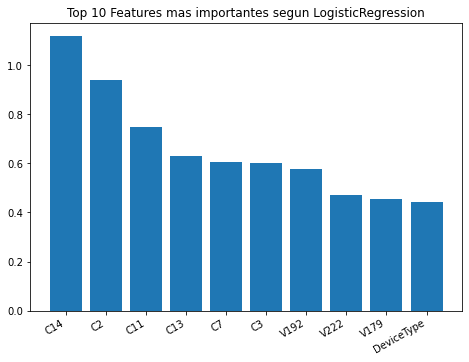

In [62]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature_names,feature_weights)
ax.set_title("Top 10 Features mas importantes segun LogisticRegression")
plt.xticks(rotation=30, ha='right')
plt.show()